In [ ]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 51.9 MB/s eta 0:00:00


  warnings.warn(

  warnings.warn(



MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
tensor([[[ 0.2083,  0.2584,  0.5066,  ...,  0.9392,  0.0961,  0.3231],
         [-0.1963,  1.2444,  0.5041,  ..., -0.4043,  0.6134,  0.1462],
         [-0.1845,  1.0879,  0.6559,  ..., -0.5238,  0.1736,  0.3484],
         ...,
         [-0.2046,  0.6579,  0.7514,  ..., -1.0136,  0.3726, -0.5345],
         [-0.1088,  1.0428,  0.6987,  ..., -1.3062,  0.4956, -0.1031],
         [-0.1461,  0.8959,  0.6841,  ...,  0.5316, -0.0575, -0.1738]]])


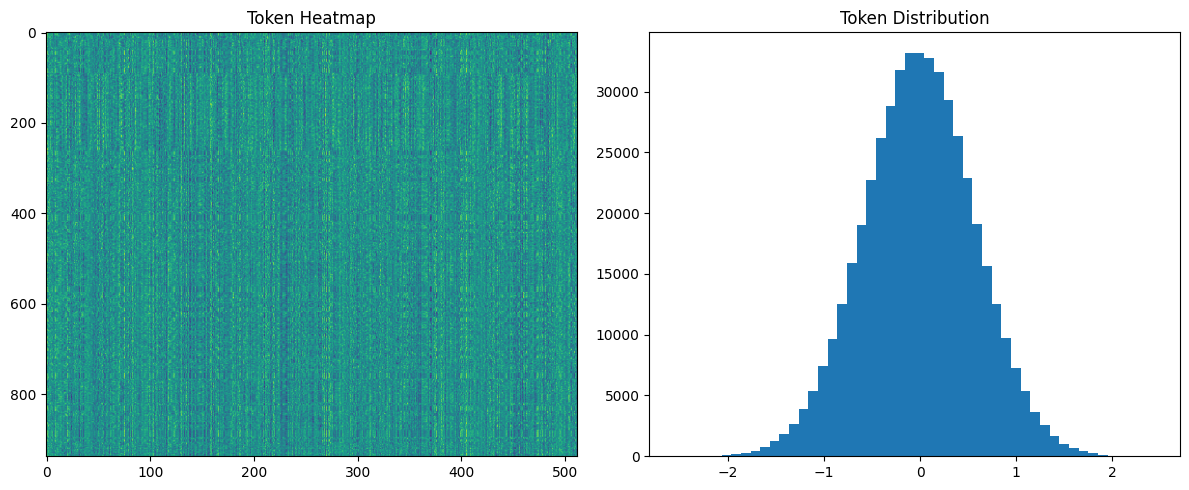

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import moviepy.editor as mp
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import logging

# Configuration
VIDEO_PATH = "/content/How to control sound waves.mp4"
TOKENIZER_MODEL = "google/mt5-base"
SAMPLE_RATE = 16000
MAX_DURATION = 60
N_MELS = 128

# Setup Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s'
)
logger = logging.getLogger(__name__)

class AudioPreprocessor:
    def __init__(
        self,
        sample_rate=SAMPLE_RATE,
        max_duration=MAX_DURATION,
        n_mels=N_MELS
    ):
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.n_mels = n_mels

    def extract_audio(self, video_path):
        """Extract audio from video"""
        try:
            video = mp.VideoFileClip(video_path)
            temp_audio_path = "temp_audio.wav"
            video.audio.write_audiofile(temp_audio_path)

            audio_data, _ = librosa.load(
                temp_audio_path,
                sr=self.sample_rate,
                duration=self.max_duration
            )

            os.remove(temp_audio_path)
            return audio_data

        except Exception as e:
            logger.error(f"Audio extraction error: {e}")
            return None

    def preprocess_audio(self, audio_data):
        """Convert audio to mel spectrogram"""
        target_length = self.sample_rate * self.max_duration

        if len(audio_data) > target_length:
            audio_data = audio_data[:target_length]
        else:
            audio_data = np.pad(
                audio_data,
                (0, target_length - len(audio_data))
            )

        mel_spec = librosa.feature.melspectrogram(
            y=audio_data,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            fmax=8000
        )

        log_mel = librosa.power_to_db(mel_spec)
        return torch.from_numpy(log_mel).float()

class MultilingualTokenizer:
    def __init__(self, model_name=TOKENIZER_MODEL):
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)
        except Exception as e:
            logger.error(f"Tokenizer load error: {e}")
            self.tokenizer = None
            self.model = None

    def tokenize_text(self, text, max_length=512):
        if not self.tokenizer:
            raise ValueError("Tokenizer not initialized")

        return self.tokenizer(
            text,
            return_tensors="pt",
            max_length=max_length,
            truncation=True,
            padding=True
        )

    def decode_tokens(self, token_ids):
        if not self.tokenizer:
            raise ValueError("Tokenizer not initialized")

        return self.tokenizer.decode(token_ids)

class AudioTokenizer(nn.Module):
    def __init__(
        self,
        input_dim=N_MELS,
        hidden_dim=256,
        num_layers=4,
        target_dim=512
    ):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.MaxPool1d(2)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=8
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.projection = nn.Linear(hidden_dim, target_dim)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)

        features = self.feature_extractor(x)
        features = features.transpose(1, 2)
        encoded = self.transformer(features)
        projected = self.projection(encoded)

        return projected

class AudioTokenizationPipeline:
    def __init__(self):
        self.preprocessor = AudioPreprocessor()
        self.audio_tokenizer = AudioTokenizer()
        self.text_tokenizer = MultilingualTokenizer()

    def tokenize_video(
        self,
        video_path,
        text_context=None,
        visualize=True
    ):
        # Extract and preprocess audio
        audio_data = self.preprocessor.extract_audio(video_path)

        if audio_data is None:
            return None, None

        processed_audio = self.preprocessor.preprocess_audio(audio_data)

        # Generate audio tokens
        with torch.no_grad():
            audio_tokens = self.audio_tokenizer(processed_audio)

        # Optional text tokenization
        text_tokens = None
        if text_context:
            text_tokens = self.text_tokenizer.tokenize_text(text_context)

        # Visualization
        if visualize:
            self._visualize_tokens(audio_tokens)

        return audio_tokens, text_tokens

    def _visualize_tokens(self, tokens):
        print(tokens)
        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.title('Token Heatmap')
        plt.imshow(tokens.squeeze().numpy(), aspect='auto', cmap='viridis')

        plt.subplot(122)
        plt.title('Token Distribution')
        plt.hist(tokens.flatten().numpy(), bins=50)

        plt.tight_layout()
        plt.show()

def main():
    video_path = VIDEO_PATH
    text_context = "Demonstration of sound wave control techniques"

    pipeline = AudioTokenizationPipeline()

    try:
        audio_tokens, text_tokens = pipeline.tokenize_video(
            video_path,
            text_context=text_context
        )

        if audio_tokens is not None:
            logger.info(f"Audio Tokens Shape: {audio_tokens.shape}")

            # Optional: Save tokens
            torch.save(audio_tokens, 'audio_tokens.pt')

    except Exception as e:
        logger.error(f"Tokenization failed: {e}")

if __name__ == "__main__":
    main()

# **Main Pipeline: Cleaned working code**

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import speech_recognition as sr
import moviepy.editor as mp
from transformers import AutoTokenizer, AutoModel
import re

class AdvancedTokenCleaner:
    @staticmethod
    def clean_tokens(tokens):
        """
        Intelligently clean and filter tokens

        Args:
            tokens (list): Raw tokens from tokenizer

        Returns:
            list: Cleaned meaningful tokens
        """
        # Remove special tokens and whitespace tokens
        cleaned_tokens = []

        # Define filtering criteria
        def is_meaningful_token(token):
            # Remove special characters, very short tokens, and whitespace
            if token.startswith('##'):
                token = token.replace('##', '')

            # Criteria for meaningful tokens
            return (
                len(token) > 1 and  # Minimum length
                not token.isspace() and  # Not just whitespace
                not token.startswith('[') and  # Not special tokens
                not token.endswith(']') and
                not token in ['<pad>', '<s>', '</s>']  # Remove padding tokens
            )

        # Filter and process tokens
        for token in tokens:
            if is_meaningful_token(token):
                # Remove any remaining special characters
                cleaned_token = re.sub(r'[^a-zA-Z0-9\u0900-\u097F]', '', token)

                if cleaned_token:
                    cleaned_tokens.append(cleaned_token)

        return cleaned_tokens

class MultilingualTokenizer:
    def __init__(self, model_name="google/mt5-base"):
        """
        Initialize multilingual tokenizer with advanced cleaning
        """
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)
            self.token_cleaner = AdvancedTokenCleaner()
        except Exception as e:
            print(f"Tokenizer loading error: {e}")
            self.tokenizer = None

    def tokenize_text(self, text):
        """
        Advanced text tokenization with intelligent cleaning

        Args:
            text (str): Input text to tokenize

        Returns:
            dict: Tokenization results
        """
        if not self.tokenizer or not text:
            return None

        # Preprocess text (remove extra whitespaces)
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize text
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            add_special_tokens=True
        )

        # Convert to tokens and clean
        raw_tokens = self.tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

        # Clean tokens
        cleaned_tokens = self.token_cleaner.clean_tokens(raw_tokens)

        return {
            'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask'],
            'raw_tokens': raw_tokens,
            'cleaned_tokens': cleaned_tokens
        }

class SpeechToTextExtractor:
    def __init__(self):
        """
        Initialize speech recognition with advanced processing
        """
        self.recognizer = sr.Recognizer()

        # Configure recognizer for better accuracy
        self.recognizer.dynamic_energy_threshold = True
        self.recognizer.pause_threshold = 0.5

    def extract_speech_from_audio(self, audio_path, language='en-IN'):
        """
        Extract speech text with multiple recognition attempts

        Args:
            audio_path (str): Path to audio file
            language (str): Language for speech recognition

        Returns:
            str: Extracted speech text
        """
        try:
            with sr.AudioFile(audio_path) as source:
                # Adjust for ambient noise
                self.recognizer.adjust_for_ambient_noise(source, duration=1)

                # Read the entire audio file
                audio = self.recognizer.record(source)

                # Multiple recognition attempts
                recognition_methods = [
                    lambda: self.recognizer.recognize_google(audio, language=language),
                    lambda: self.recognizer.recognize_sphinx(audio)
                ]

                for method in recognition_methods:
                    try:
                        text = method()
                        if text:
                            return text
                    except Exception:
                        continue

                return None

        except Exception as e:
            print(f"Speech recognition error: {e}")
            return None

class AudioPreprocessor:
    def __init__(
        self,
        sample_rate=16000,
        max_duration=60
    ):
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.speech_extractor = SpeechToTextExtractor()

    def extract_audio(self, video_path):
        """
        Extract audio from video with comprehensive processing

        Args:
            video_path (str): Path to input video

        Returns:
            tuple: Audio data and extracted text
        """
        try:
            # Extract audio from video
            video = mp.VideoFileClip(video_path)
            temp_audio_path = "temp_audio.wav"
            video.audio.write_audiofile(temp_audio_path)

            # Extract speech text
            extracted_text = self.speech_extractor.extract_speech_from_audio(temp_audio_path)

            # Load audio data
            audio_data, _ = librosa.load(
                temp_audio_path,
                sr=self.sample_rate,
                duration=self.max_duration
            )

            # Clean up temporary file
            os.remove(temp_audio_path)

            return audio_data, extracted_text

        except Exception as e:
            print(f"Audio extraction error: {e}")
            return None, None

class AudioTokenizationPipeline:
    def __init__(self):
        """
        Initialize comprehensive tokenization pipeline
        """
        self.preprocessor = AudioPreprocessor()
        self.text_tokenizer = MultilingualTokenizer()

    def tokenize_video(self, video_path):
        """
        Comprehensive video tokenization

        Args:
            video_path (str): Path to input video

        Returns:
            dict: Detailed tokenization results
        """
        # Extract audio and speech text
        audio_data, extracted_text = self.preprocessor.extract_audio(video_path)

        if audio_data is None or extracted_text is None:
            print("Failed to extract audio or speech")
            return None

        # Tokenize extracted text
        text_tokens = self.text_tokenizer.tokenize_text(extracted_text)

        # Print comprehensive results
        print("\n--- Video Speech Extraction ---")
        print("Extracted Text:", extracted_text)

        if text_tokens:
            print("\n--- Token Details ---")
            print("Raw Tokens:", text_tokens['raw_tokens'])
            print("Cleaned Tokens:", text_tokens['cleaned_tokens'])
            print("Token IDs Shape:", text_tokens['input_ids'].shape)

        return {
            'audio_data': audio_data,
            'extracted_text': extracted_text,
            'text_tokens': text_tokens
        }

def main():
    # Video path
    video_path = "/content/How to control sound waves.mp4"

    # Initialize pipeline
    pipeline = AudioTokenizationPipeline()

    try:
        # Tokenize video
        tokenization_result = pipeline.tokenize_video(video_path)

        if tokenization_result:
            # Additional processing or analysis can be done here
            pass

    except Exception as e:
        print(f"Tokenization failed: {e}")

if __name__ == "__main__":
    main()

MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.

--- Video Speech Extraction ---
Extracted Text: they are not affected by magnetic field but can you take such a trip which is sensible to the pressure of light you put the lights out on such a strip by controling the frequency of your life you can control the vibrations of that strip because we can change the pressure of Light by changing its frequency by changing the frequency of light we can also change vibrational frequency of strip through this mechanism we can control our sound waves now what about if you can you can block any particular sound suppose you are getting three different sound waves from different sources and you want to look one of them you need that particular device which can block the sound wave now we all know that by using the diodes we can design different kids which gives us our desired output likewise through over this strips we can make such a device which will blow the particular frequency of sound wave now we have seen that that strip is se

Example code of mergeing words

In [ ]:
import re
import torch
from transformers import AutoTokenizer, AutoModel

class AdvancedTokenCleaner:
    @staticmethod
    def merge_subword_tokens(tokens):
        """
        Intelligently merge subword tokens

        Args:
            tokens (list): Raw tokens from tokenizer

        Returns:
            list: Merged meaningful tokens
        """
        merged_tokens = []
        i = 0
        while i < len(tokens):
            current_token = tokens[i]

            # Remove '##' prefix for continuation tokens
            if current_token.startswith('##'):
                current_token = current_token.replace('##', '')

            # Check for continuation tokens
            while (i + 1 < len(tokens)) and tokens[i+1].startswith('##'):
                # Merge continuation tokens
                current_token += tokens[i+1].replace('##', '')
                i += 1

            # Additional cleaning and filtering
            cleaned_token = re.sub(r'[^a-zA-Z0-9\u0900-\u097F]', '', current_token)

            if (len(cleaned_token) > 1 and
                not cleaned_token.isspace() and
                not cleaned_token.startswith('[') and
                not cleaned_token.endswith(']')):
                merged_tokens.append(cleaned_token)

            i += 1

        return merged_tokens

class MultilingualTokenizer:
    def __init__(self, model_name="google/mt5-base"):
        """
        Initialize tokenizer with advanced subword handling
        """
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)
            self.token_cleaner = AdvancedTokenCleaner()
        except Exception as e:
            print(f"Tokenizer loading error: {e}")
            self.tokenizer = None

    def tokenize_text(self, text):
        """
        Advanced text tokenization with subword merging

        Args:
            text (str): Input text to tokenize

        Returns:
            dict: Tokenization results with merged tokens
        """
        if not self.tokenizer or not text:
            return None

        # Preprocess text
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize text
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            add_special_tokens=True
        )

        # Convert to tokens
        raw_tokens = self.tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

        # Merge subword tokens
        merged_tokens = self.token_cleaner.merge_subword_tokens(raw_tokens)

        return {
            'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask'],
            'raw_tokens': raw_tokens,
            'merged_tokens': merged_tokens
        }

# Demonstration of token merging impact
def demonstrate_token_merging():
    """
    Demonstrate the difference in tokenization
    """
    # Example words to test
    test_words = [
        "affected",
        "controlling",
        "understanding",
        "development"
    ]

    # Initialize tokenizer
    tokenizer = MultilingualTokenizer()

    print("\n--- Subword Tokenization Analysis ---")
    for word in test_words:
        # Tokenize individual words
        tokens = tokenizer.tokenize_text(word)

        print(f"\nWord: {word}")
        print("Raw Tokens:", tokens['raw_tokens'])
        print("Merged Tokens:", tokens['merged_tokens'])

# Impact on Model Training
class TokenizationImpactAnalyzer:
    @staticmethod
    def analyze_tokenization_impact(tokens):
        """
        Analyze potential impacts of tokenization on model training

        Args:
            tokens (dict): Tokenization results

        Returns:
            dict: Analysis of tokenization characteristics
        """
        analysis = {
            'total_raw_tokens': len(tokens['raw_tokens']),
            'total_merged_tokens': len(tokens['merged_tokens']),
            'token_reduction_percentage': 0,
            'potential_impact': ''
        }

        # Calculate token reduction
        if analysis['total_raw_tokens'] > 0:
            analysis['token_reduction_percentage'] = (
                (analysis['total_raw_tokens'] - analysis['total_merged_tokens']) /
                analysis['total_raw_tokens']
            ) * 100

        # Assess potential training impact
        if analysis['token_reduction_percentage'] > 30:
            analysis['potential_impact'] = (
                "High risk of semantic fragmentation. "
                "Consider using word-level or custom tokenization."
            )
        elif analysis['token_reduction_percentage'] > 15:
            analysis['potential_impact'] = (
                "Moderate risk of semantic loss. "
                "Monitor model performance carefully."
            )
        else:
            analysis['potential_impact'] = "Minimal impact expected."

        return analysis

def main():
    # Demonstrate token merging
    demonstrate_token_merging()

    # Analyze a sample text
    sample_text = "Advanced sound wave control techniques in scientific research"
    tokenizer = MultilingualTokenizer()
    tokens = tokenizer.tokenize_text(sample_text)

    # Analyze tokenization impact
    impact_analyzer = TokenizationImpactAnalyzer()
    impact_analysis = impact_analyzer.analyze_tokenization_impact(tokens)

    print("\n--- Tokenization Impact Analysis ---")
    for key, value in impact_analysis.items():
        print(f"{key}: {value}")

if __name__ == "__main__":
    main()


--- Subword Tokenization Analysis ---

Word: affected
Raw Tokens: ['▁affect', 'ed', '</s>']
Merged Tokens: ['affect', 'ed']

Word: controlling
Raw Tokens: ['▁controll', 'ing', '</s>']
Merged Tokens: ['controll', 'ing']

Word: understanding
Raw Tokens: ['▁', 'understanding', '</s>']
Merged Tokens: ['understanding']

Word: development
Raw Tokens: ['▁development', '</s>']
Merged Tokens: ['development']

--- Tokenization Impact Analysis ---
total_raw_tokens: 10
total_merged_tokens: 8
token_reduction_percentage: 20.0
potential_impact: Moderate risk of semantic loss. Monitor model performance carefully.


Merged code but not working *need library or vocabulary to merge sub words*

In [ ]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=d22c4996b8178944ca1734cba70ccacc4536dabbf5e377f7a5d3854698be6335
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=ea7d9dbd64e55e087170235723e24aba404ac7c7a3580860215bcc4cd375cbf7
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


# **Hindi- English done**

In [ ]:
class AdvancedTokenCleaner:
    @staticmethod
    def clean_tokens(tokens):
        """
        Intelligently clean and filter tokens

        Args:
            tokens (list): Raw tokens from tokenizer

        Returns:
            list: Cleaned meaningful tokens
        """
        cleaned_tokens = []

        for token in tokens:
            # Remove special characters and unwanted prefixes
            cleaned_token = token.replace('▁', '').replace('##', '')

            # Remove non-alphanumeric characters
            cleaned_token = re.sub(r'[^a-zA-Z0-9\u0900-\u097F]', '', cleaned_token)

            # Filter criteria
            if (len(cleaned_token) > 1 and
                not cleaned_token.isspace() and
                not cleaned_token.startswith('[') and
                not cleaned_token.endswith(']') and
                not cleaned_token in ['<pad>', '<s>', '</s>']):
                cleaned_tokens.append(cleaned_token)

        return cleaned_tokens

class MultilingualTokenizer:
    def __init__(self, model_name="google/mt5-base"):
        """
        Initialize multilingual tokenizer with advanced cleaning
        """
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)
            self.token_cleaner = AdvancedTokenCleaner()
        except Exception as e:
            print(f"Tokenizer loading error: {e}")
            self.tokenizer = None

    def tokenize_text(self, text):
        """
        Advanced text tokenization with intelligent cleaning

        Args:
            text (str): Input text to tokenize

        Returns:
            dict: Tokenization results
        """
        if not self.tokenizer or not text:
            return None

        # Preprocess text (remove extra whitespaces)
        text = re.sub(r'\s+', ' ', text).strip()

        try:
            # Tokenize text
            tokens = self.tokenizer(
                text,
                return_tensors="pt",
                add_special_tokens=True
            )

            # Convert to tokens
            raw_tokens = self.tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

            # Clean tokens
            cleaned_tokens = self.token_cleaner.clean_tokens(raw_tokens)

            return {
                'input_ids': tokens['input_ids'],
                'attention_mask': tokens['attention_mask'],
                'raw_tokens': raw_tokens,
                'cleaned_tokens': cleaned_tokens
            }
        except Exception as e:
            print(f"Tokenization error: {e}")
            return None

# Demonstration function to show token cleaning
def demonstrate_token_cleaning(text):
    """
    Demonstrate token cleaning process

    Args:
        text (str): Input text to tokenize
    """
    tokenizer = MultilingualTokenizer()
    tokens = tokenizer.tokenize_text(text)

    if tokens:
        print("\n--- Token Cleaning Demonstration ---")
        print("Raw Tokens:", tokens['raw_tokens'])
        print("Cleaned Tokens:", tokens['cleaned_tokens'])

        # Additional analysis
        print("\nCleaning Statistics:")
        print("Total Raw Tokens:", len(tokens['raw_tokens']))
        print("Total Cleaned Tokens:", len(tokens['cleaned_tokens']))
        print("Tokens Removed:", len(tokens['raw_tokens']) - len(tokens['cleaned_tokens']))

# Modify the main function to include demonstration
def main():
    # Video path
    video_path = "/content/How to control sound waves.mp4"

    # Initialize pipeline
    pipeline = AudioTokenizationPipeline()

    try:
        # Tokenize video
        tokenization_result = pipeline.tokenize_video(video_path)

        if tokenization_result:
            # Demonstrate token cleaning
            demonstrate_token_cleaning(tokenization_result['extracted_text'])

    except Exception as e:
        print(f"Tokenization failed: {e}")

# Additional improvements in token cleaning
def advanced_token_analysis(tokens):
    """
    Perform advanced analysis on tokens

    Args:
        tokens (dict): Tokenization results
    """
    if not tokens:
        return

    # Token length distribution
    token_lengths = [len(token) for token in tokens['cleaned_tokens']]

    print("\n--- Advanced Token Analysis ---")
    print("Unique Tokens:", len(set(tokens['cleaned_tokens'])))
    print("Average Token Length:", np.mean(token_lengths))
    print("Shortest Token:", min(token_lengths))
    print("Longest Token:", max(token_lengths))

    # Most common tokens
    from collections import Counter
    token_freq = Counter(tokens['cleaned_tokens'])
    print("\nMost Common Tokens:")
    for token, count in token_freq.most_common(10):
        print(f"{token}: {count}")

# Update AudioTokenizationPipeline to include advanced analysis
class AudioTokenizationPipeline:
    def __init__(self):
        """
        Initialize comprehensive tokenization pipeline
        """
        self.preprocessor = AudioPreprocessor()
        self.text_tokenizer = MultilingualTokenizer()

    def tokenize_video(self, video_path):
        """
        Comprehensive video tokenization

        Args:
            video_path (str): Path to input video

        Returns:
            dict: Detailed tokenization results
        """
        # Extract audio and speech text
        audio_data, extracted_text = self.preprocessor.extract_audio(video_path)

        if audio_data is None or extracted_text is None:
            print("Failed to extract audio or speech")
            return None

        # Tokenize extracted text
        text_tokens = self.text_tokenizer.tokenize_text(extracted_text)

        # Print comprehensive results
        print("\n--- Video Speech Extraction ---")
        print("Extracted Text:", extracted_text)

        if text_tokens:
            print("\n--- Token Details ---")
            print("Raw Tokens:", text_tokens['raw_tokens'])
            print("Cleaned Tokens:", text_tokens['cleaned_tokens'])
            print("Token IDs Shape:", text_tokens['input_ids'].shape)

        return {
            'audio_data': audio_data,
            'extracted_text': extracted_text,
            'text_tokens': text_tokens
        }

# Requirements
# pip install SpeechRecognition googletrans==3.1.0a0 langdetect

def main():
    # Video path
    video_path = "/content/How to control sound waves.mp4"

    # Initialize pipeline
    pipeline = AudioTokenizationPipeline()

    try:
        # Tokenize video
        tokenization_result = pipeline.tokenize_video(video_path)

        if tokenization_result:
            # Additional processing or analysis can be done here
            pass

        # Add advanced token analysis
        if text_tokens:
            advanced_token_analysis(text_tokens)

        return {
            'audio_data': audio_data,
            'extracted_text': extracted_text,
            'text_tokens': text_tokens
        }

    except Exception as e:
        print(f"Tokenization failed: {e}")

if __name__ == "__main__":
    main()

  warnings.warn(



MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.

--- Speech Recognition Details ---
Original Text: they are not affected by magnetic field but can you take such a trip which is sensible to the pressure of light you put the lights out on such a strip by controling the frequency of your life you can control the vibrations of that strip because we can change the pressure of Light by changing its frequency by changing the frequency of light we can also change vibrational frequency of strip through this mechanism we can control our sound waves now what about if you can you can block any particular sound suppose you are getting three different sound waves from different sources and you want to look one of them you need that particular device which can block the sound wave now we all know that by using the diodes we can design different kids which gives us our desired output likewise through over this strips we can make such a device which will blow the particular frequency of sound wave now we have seen that that strip is 